In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "ranked_quadh_mp"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


In [6]:
# bkg.reweight(2.3)
# bkg.set_systematics(0.2)

In [7]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None, None, None, None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221124_ranger_lr0.0047_batch512_m7m10m12/"


In [11]:
(signal+bkg+data).apply(lambda t : eightb.load_quadh(t, path), report=True)
# (signal).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


[None, None, None, None, None, None, None, None]

100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


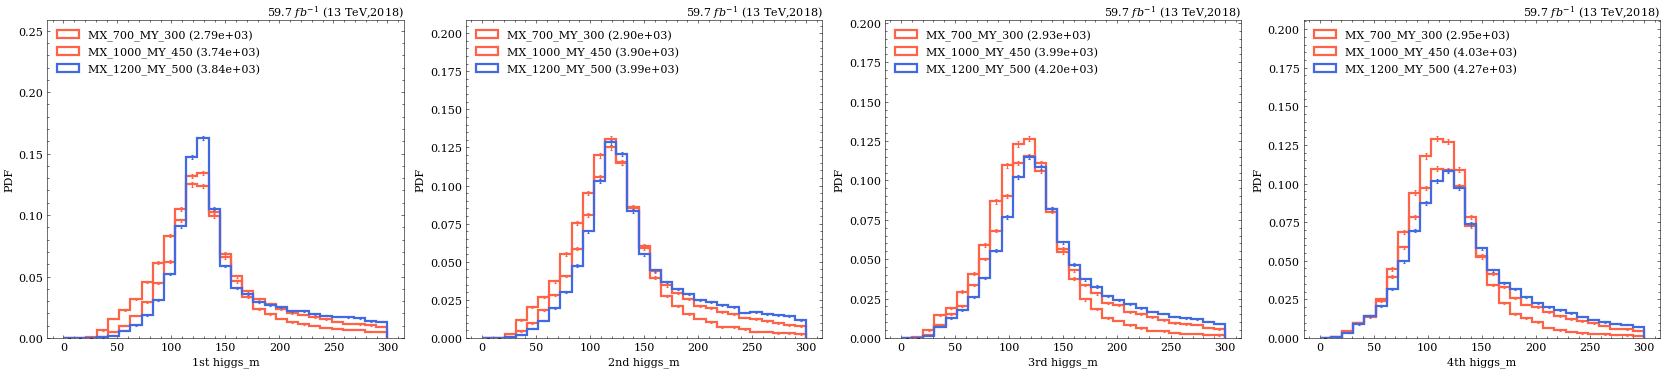

In [12]:
study.quick( 
    signal[[0,6,7]] + bkg, 
    legend=True, efficiency=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
)

In [13]:
# event_filter = FilterSequence(
#     eightb.selected_jet_ptregressed(),
#     eightb.selected_jet_btagwp()
# )

# signal = signal.apply(event_filter)
# bkg = bkg.apply(event_filter)
# data = data.apply(event_filter)

In [14]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)
signal.apply(nfound_higgs)

[None, None, None, None, None, None, None, None]

In [15]:
(signal+bkg+data).apply(lambda t : eightb.pair_y_from_higgs(t, operator=eightb.y_min_mass_asym), report=True)

100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


[None, None, None, None, None, None, None, None]

In [16]:
def build_bdt_features(t):
    jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)

    j1_phi, j2_phi = ak.unzip(ak.combinations(t.jet_phi, n=2, axis=-1))
    jet_dphi = calc_dphi(j1_phi, j2_phi)

    j1_eta, j2_eta = ak.unzip(ak.combinations(t.jet_eta, n=2, axis=-1))
    jet_deta = calc_deta(j1_eta, j2_eta)

    min_jet_deta = ak.min( np.abs(jet_deta), axis=-1)
    max_jet_deta = ak.max( np.abs(jet_deta), axis=-1)

    jet_dr = np.sqrt( jet_deta**2 + jet_dphi**2 )

    min_jet_dr = ak.min(jet_dr, axis=-1)
    max_jet_dr = ak.max(jet_dr, axis=-1)

    h1_phi, h2_phi = ak.unzip(ak.combinations(t.higgs_phi, n=2, axis=-1))
    higgs_dphi = np.abs(calc_dphi(h1_phi, h2_phi))

    h1_eta, h2_eta = ak.unzip(ak.combinations(t.higgs_eta, n=2, axis=-1))
    higgs_deta = np.abs(calc_deta(h1_eta, h2_eta))

    higgs_comb_id = ak.combinations( np.arange(4), n=2, axis=0).tolist()

    t.extend(
        jet_ht=jet_ht,
        min_jet_deta=min_jet_deta,
        max_jet_deta=max_jet_deta,
        min_jet_dr=min_jet_dr,
        max_jet_dr=max_jet_dr,
        **{
            f'h{i+1}{j+1}_dphi':higgs_dphi[:,k]
            for k, (i,j) in enumerate(higgs_comb_id)
        },
        **{
            f'h{i+1}{j+1}_deta':higgs_deta[:,k]
            for k, (i,j) in enumerate(higgs_comb_id)
        },
        **{
            f'h{i+1}_{var}':t[f'higgs_{var}'][:,i]
            for i in range(4)
            for var in ('pt','dr')
        },
    )
(signal+bkg+data).apply(build_bdt_features, report=True)

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


[None, None, None, None, None, None, None, None]

In [99]:
(signal+bkg+data).write(
    f"{dout}_{{base}}"
)

Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_700_MY_300/ranked_quadh_mp_ntuple.root


[65.75MB/65.75MB][100%][==================================================][65.75MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_800_MY_300/ranked_quadh_mp_ntuple.root


[76.61MB/76.61MB][100%][==================================================][76.61MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_800_MY_350/ranked_quadh_mp_ntuple.root


[78.41MB/78.41MB][100%][==================================================][39.21MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_900_MY_300/ranked_quadh_mp_ntuple.root


[80.39MB/80.39MB][100%][==================================================][40.2MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_900_MY_400/ranked_quadh_mp_ntuple.root


[86.59MB/86.59MB][100%][==================================================][86.59MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1000_MY_300/ranked_quadh_mp_ntuple.root


[82.28MB/82.28MB][100%][==================================================][82.28MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1000_MY_450/ranked_quadh_mp_ntuple.root


[92.58MB/92.58MB][100%][==================================================][92.58MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1200_MY_500/ranked_quadh_mp_ntuple.root


[100.4MB/100.4MB][100%][==================================================][100.4MB/s]  


[None, None, None, None, None, None, None, None]